In [ ]:
!nvidia-smi

Tue Jan 11 03:58:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.python.client import device_lib
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
import seaborn as sns
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time
%matplotlib inline

In [2]:
print(tf.__version__)
print(device_lib.list_local_devices())
running_env = "colab"
# running_env = "local"

2.7.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14329251084367739441
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12408465197165174396
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [3]:
if running_env == "colab":
  train_df = pd.read_csv('/content/drive/MyDrive/steel-defect-detection/input/train.csv')
else:
  train_df = pd.read_csv('input/train.csv')

train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
train_df = train_df.groupby('ImageId')['ClassId'].apply(list).reset_index()
train_df[:6]

,ImageId,ClassId
0,0002cc93b.jpg,[1]
1,0007a71bf.jpg,[3]
2,000a4bcdd.jpg,[1]
3,000f6bf48.jpg,[4]
4,0014fce06.jpg,[3]
5,0025bde0c.jpg,"[3, 4]"


In [5]:
mlb = MultiLabelBinarizer()
data = mlb.fit_transform(train_df['ClassId'])
defects_columns = []

for column in list(mlb.classes_):
  defects_columns.append("defect_"+ str(column))

onehot_encoded_classes_df = pd.DataFrame(data, columns=defects_columns)
onehot_encoded_classes_df[:6]

,defect_1,defect_2,defect_3,defect_4
0,1,0,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,1,0
5,0,0,1,1


In [6]:
train_df = pd.concat([train_df.drop('ClassId',axis=1), onehot_encoded_classes_df], axis=1)
train_df.head(10)

,ImageId,defect_1,defect_2,defect_3,defect_4
0,0002cc93b.jpg,1,0,0,0
1,0007a71bf.jpg,0,0,1,0
2,000a4bcdd.jpg,1,0,0,0
3,000f6bf48.jpg,0,0,0,1
4,0014fce06.jpg,0,0,1,0
5,0025bde0c.jpg,0,0,1,1
6,002af848d.jpg,0,0,0,1
7,002fc4e19.jpg,1,1,0,0
8,0030401a5.jpg,0,0,0,1
9,0046839bd.jpg,0,0,1,0


In [7]:
train_df.shape

(6666, 5)

In [8]:
if running_env == "colab":
    data_dir = '/content/drive/MyDrive/steel-defect-detection/'
else:
    data_dir = ''

test_path = data_dir + 'input/test_images'
train_path = data_dir + 'input/train_images'

In [9]:
steel_image = train_path + '/' + os.listdir(train_path)[0]
imread(steel_image).shape

(256, 1600, 3)

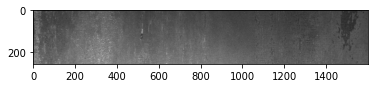

In [10]:
plt.imshow(imread(steel_image))

In [11]:
image_shape = imread(steel_image).shape
IMAGE_SIZE = list(image_shape)

In [12]:
train_df_permutated = train_df.sample(frac=1)
batch_size = 32
train_size = 0.8
validation_size = 0.1
test_size = 0.1
train_end = int(len(train_df_permutated) * train_size)
validation_end = int(len(train_df_permutated) * (train_size + validation_size))
df_train = train_df_permutated[:train_end]
df_validation = train_df_permutated[train_end: validation_end]
df_test = train_df_permutated[validation_end:]

x_column = list(df_train.columns)[0]
y_columns = list(df_train.columns)[1:]
train_datagen = ImageDataGenerator(rescale=1./255.)
validation_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=df_train,
                  directory=train_path,
                  x_col=x_column,
                  y_col=y_columns,
                  batch_size=batch_size,
                  seed=42,
                  shuffle=True,
                  class_mode="raw",
                  target_size=image_shape[:-1])

validation_generator = validation_datagen.flow_from_dataframe(
                dataframe=df_validation,
                directory=train_path,
                x_col=x_column,
                y_col=y_columns,
                batch_size=batch_size,
                seed=42,
                shuffle=True,
                class_mode="raw",
                target_size=image_shape[:-1])

test_generator = test_datagen.flow_from_dataframe(
                  dataframe=df_test,
                  directory=train_path,
                  x_col=x_column,
                  batch_size=batch_size,
                  seed=42,
                  shuffle=False,
                  class_mode=None,
                  target_size=image_shape[:-1])

Found 5332 validated image filenames.
Found 667 validated image filenames.
Found 667 validated image filenames.


In [13]:
steps_per_epoch = df_train.shape[0] / batch_size
validation_steps = df_validation.shape[0] / batch_size

In [14]:
X, y = next(train_generator)
print(X.shape, y.shape)
X = next(test_generator)
print(X.shape)

(32, 256, 1600, 3) (32, 4)
(32, 256, 1600, 3)


In [ ]:
# inceptionv3 = InceptionV3(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

# for layer in inceptionv3.layers:
#     layer.trainable = False

In [ ]:
# inception_op = Flatten()(inceptionv3.output)
# prediction = Dense(4, activation='sigmoid')(inception_op)

# model = Model(inputs=inceptionv3.input, outputs=prediction)
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 127, 799, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 799, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
inceptionv4 = InceptionResNetV2(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

for layer in inceptionv4.layers:
    layer.trainable = False

219070464/219055592 [==============================] - 2s 0us/step


In [16]:
inception_op = Flatten()(inceptionv4.output)
prediction = Dense(4, activation='sigmoid')(inception_op)

model = Model(inputs=inceptionv4.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 127, 799, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 799, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
    )

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
trained_model = model.fit_generator(generator=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=validation_generator,
                                    validation_steps=validation_steps,
                                    epochs=50,
                                    callbacks = [early_stop],
                                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
166/166 [==============================] - 970s 6s/step - loss: 2.6306 - accuracy: 0.8065 - val_loss: 1.0047 - val_accuracy: 0.8876
Epoch 2/50
166/166 [==============================] - 730s 4s/step - loss: 0.5473 - accuracy: 0.9141 - val_loss: 1.3161 - val_accuracy: 0.8471
Epoch 3/50
166/166 [==============================] - 730s 4s/step - loss: 0.4720 - accuracy: 0.9317 - val_loss: 1.3650 - val_accuracy: 0.8711
Epoch 4/50
166/166 [==============================] - 730s 4s/step - loss: 0.2439 - accuracy: 0.9480 - val_loss: 1.7779 - val_accuracy: 0.8876
Epoch 5/50
166/166 [==============================] - 735s 4s/step - loss: 0.2669 - accuracy: 0.9475 - val_loss: 1.7661 - val_accuracy: 0.8876
Epoch 6/50
166/166 [==============================] - 736s 4s/step - loss: 0.2413 - accuracy: 0.9526 - val_loss: 1.8864 - val_accuracy: 0.8966


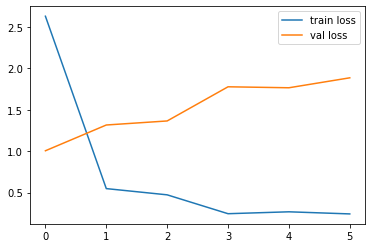

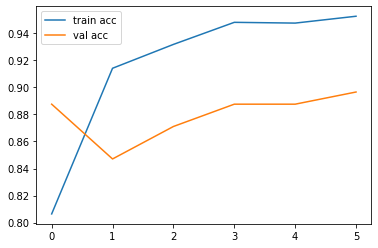

In [19]:
# plot the loss
plt.plot(trained_model.history['loss'], label='train loss')
plt.plot(trained_model.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(trained_model.history['accuracy'], label='train acc')
plt.plot(trained_model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [20]:
print(model.evaluate_generator(test_generator))
print(model.metrics_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.0, 0.0]
['loss', 'accuracy']


(256, 1600, 3)
(1, 256, 1600, 3)
[[0. 0. 1. 0.]]
['defect_1', 'defect_2', 'defect_3', 'defect_4']


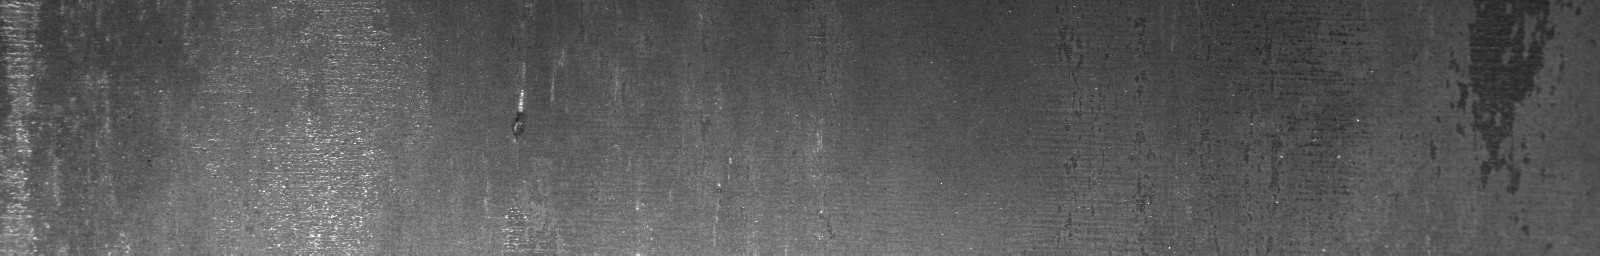

In [21]:
# Make a Prediction
test_image = image.load_img(steel_image)
test_img_arr = image.img_to_array(test_image)
print(test_img_arr.shape)
test_img_arr = test_img_arr.reshape((1,) + image_shape)
print(test_img_arr.shape)

print(model.predict(test_img_arr))
print(y_columns)
test_image

In [ ]:
# model.save(data_dir+'model/inceptionv3.h5')

In [22]:
model.save(data_dir+'model/inceptionv4.h5')

In [23]:
pred = model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [24]:
np.unique(np.rint(pred).astype(int))

array([0, 1])

In [25]:
from tensorflow.keras.models import load_model
# model = load_model(data_dir+'model/inceptionv3.h5')
model = load_model(data_dir+'model/inceptionv4.h5')

In [26]:
pred = model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [27]:
pred

array([[5.2663969e-15, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [2.7775652e-25, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 4.0238813e-01]],
      dtype=float32)

In [28]:
from sklearn.metrics import classification_report

def predictLabelForGivenThreshold(threshold):
  y_pred=[]
  for sample in list(pred):
    y_pred.append([1 if i>=threshold else 0 for i in sample ] )
  return np.array(y_pred)

y_true = df_test[y_columns].to_numpy()
y_pred  = predictLabelForGivenThreshold(0.8)
label_names = list(df_test[y_columns].columns)
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    defect_1       0.86      0.68      0.76        92
    defect_2       0.68      0.81      0.74        21
    defect_3       0.92      0.93      0.92       508
    defect_4       1.00      0.61      0.76        88

   micro avg       0.91      0.86      0.88       709
   macro avg       0.87      0.76      0.80       709
weighted avg       0.91      0.86      0.88       709
 samples avg       0.86      0.87      0.86       709



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics

print("micro: {:.2f}".format(metrics.average_precision_score(y_true, pred, average='micro')))
print("macro: {:.2f} ".format( metrics.average_precision_score(y_true, pred, average='macro')))
print("weighted: {:.2f} ".format( metrics.average_precision_score(y_true, pred, average='weighted')))

micro: 0.85
macro: 0.79 
weighted: 0.88 


In [29]:
from sklearn import metrics

print("micro: {:.2f}".format(metrics.average_precision_score(y_true, pred, average='micro')))
print("macro: {:.2f} ".format( metrics.average_precision_score(y_true, pred, average='macro')))
print("weighted: {:.2f} ".format( metrics.average_precision_score(y_true, pred, average='weighted')))

micro: 0.92
macro: 0.85 
weighted: 0.92 


In [ ]:
from sklearn.metrics import roc_auc_score
print("roc_auc_score for different averaging methods:")
print("\tmacro:{:.2} ".format(roc_auc_score(y_true, pred)))
print("\tmicro: {:.2} ".format(roc_auc_score(y_true, pred, average='micro')))
print("\tweighted: {:.2} ".format(roc_auc_score(y_true, pred, average='weighted')))

roc_auc_score for different averaging methods:
	macro:0.93 
	micro: 0.96 
	weighted: 0.89 


In [30]:
from sklearn.metrics import roc_auc_score
print("roc_auc_score for different averaging methods:")
print("\tmacro:{:.2} ".format(roc_auc_score(y_true, pred)))
print("\tmicro: {:.2} ".format(roc_auc_score(y_true, pred, average='micro')))
print("\tweighted: {:.2} ".format(roc_auc_score(y_true, pred, average='weighted')))

roc_auc_score for different averaging methods:
	macro:0.94 
	micro: 0.97 
	weighted: 0.91 


In [31]:
y_true

array([[0, 0, 1, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1]])

In [32]:
pred

array([[5.2663969e-15, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [2.7775652e-25, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 4.0238813e-01]],
      dtype=float32)